# Load ngữ liệu

In [1]:
import pandas as pd

# === 1. Đọc dữ liệu ===
train = pd.read_csv("./UIT-ViHSD/train.csv")
dev = pd.read_csv("./UIT-ViHSD/dev.csv")
test = pd.read_csv("./UIT-ViHSD/test.csv")

In [2]:
from pathlib import Path

# Thư mục muốn lưu file CSV đã fix encoding
out_dir = Path("./UIT-ViHSD-fixed")
out_dir.mkdir(parents=True, exist_ok=True)


In [3]:
output_path = out_dir / "train.csv"  # bạn đổi tên file tại đây
train.to_csv(output_path, index=False, encoding="utf-8-sig") 

In [4]:
output_path = out_dir / "dev.csv"  # bạn đổi tên file tại đây
dev.to_csv(output_path, index=False, encoding="utf-8-sig") 

In [5]:
output_path = out_dir / "test.csv"  # bạn đổi tên file tại đây
test.to_csv(output_path, index=False, encoding="utf-8-sig") 

# Thống kê và trực quan hoá ngữ liệu

## Cell 1 – Thiết lập, cấu hình, hàm tiện ích

In [6]:
# Cell 1: Thiết lập môi trường, cấu hình và hàm tiện ích chung

import os
import re
import string
from collections import Counter
import io

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer

# Nếu muốn dùng wordcloud: pip install wordcloud
try:
    from wordcloud import WordCloud
    HAS_WORDCLOUD = True
except ImportError:
    HAS_WORDCLOUD = False

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8, 5)

# Đường dẫn dữ liệu & cấu hình tên cột
DATA_DIR = "./UIT-ViHSD-fixed"
TRAIN_FILE = "train.csv"
DEV_FILE   = "dev.csv"
TEST_FILE  = "test.csv"

# 2 cột chính trong data
TEXT_COL  = "free_text"   # cột chứa câu tiếng Việt
LABEL_COL = "label_id"    # cột chứa nhãn (id)

# Thư mục gốc để lưu toàn bộ kết quả EDA
OUTPUT_DIR = "./eda_outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# -------------------------------------------------
# ĐỌC STOPWORD TIẾNG VIỆT TỪ FILE NGOÀI
# -------------------------------------------------
STOPWORDS_PATH = "./vietnamese-stopwords.txt"

def load_vietnamese_stopwords(path):
    stopwords = set()
    if not os.path.exists(path):
        print(f"[WARNING] Không tìm thấy file stopword tại: {path}")
        print("Bạn kiểm tra lại đường dẫn STOPWORDS_PATH.")
        return stopwords

    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            w = line.strip()
            if not w:
                continue
            if w.startswith("#"):
                continue
            stopwords.add(w.lower())
    print(f"[INFO] Đã load {len(stopwords)} stopwords từ {path}")
    return stopwords

VI_STOPWORDS = load_vietnamese_stopwords(STOPWORDS_PATH)

# Một số slang / từ chửi ví dụ (hãy bổ sung theo domain của bạn)
SLANG_WORDS = {
    "dm", "đm", "vcl", "vl", "cl", "clm", "cc", "wtf", "lol",
    "lồn", "địt", "đụ", "cmm", "dkm", "đéo", "mẹ", "bố"
}

# Regex pattern
EMOJI_PATTERN = re.compile(
    "["
    u"\U0001F600-\U0001F64F"
    u"\U0001F300-\U0001F5FF"
    u"\U0001F680-\U0001F6FF"
    u"\U0001F1E0-\U0001F1FF"
    u"\U00002702-\U000027B0"
    u"\U000024C2-\U0001F251"
    "]+",
    flags=re.UNICODE,
)

URL_PATTERN       = re.compile(r'https?://\S+|www\.\S+')
HASHTAG_PATTERN   = re.compile(r'#\w+')
MENTION_PATTERN   = re.compile(r'@\w+')
NUMBER_PATTERN    = re.compile(r'\d')
ELONGATED_PATTERN = re.compile(r"(.)\1{2,}", re.UNICODE)
ALPHA_DIGIT_PATTERN = re.compile(r"[A-Za-zÀ-ỹà-ỹ0-9]", re.UNICODE)

def simple_tokenize(text: str):
    """Tokenize đơn giản: lower + tách từ theo ký tự chữ/số unicode."""
    if not isinstance(text, str):
        return []
    return re.findall(r"\w+", text.lower(), flags=re.UNICODE)

# --------- HÀM TẠO ĐƯỜNG DẪN CON ---------

def out_path(subdir: str, filename: str) -> str:
    """
    Tạo đường dẫn đầy đủ: OUTPUT_DIR / subdir / filename
    và đảm bảo thư mục con tồn tại.
    """
    dir_path = os.path.join(OUTPUT_DIR, subdir) if subdir else OUTPUT_DIR
    os.makedirs(dir_path, exist_ok=True)
    return os.path.join(dir_path, filename)

def save_table(obj, filename, subdir="misc"):
    """
    VỪA in ra màn hình, VỪA lưu Series/DataFrame xuống file CSV
    trong thư mục con OUTPUT_DIR/subdir.
    """
    print(f"\n=== {subdir}/{filename} ===")
    print(obj)

    path = out_path(subdir, filename)
    if isinstance(obj, pd.Series):
        obj.to_csv(path, header=True)
    else:
        obj.to_csv(path)
    print(f"[saved table] {path}")

def save_text(text, filename, subdir="misc"):
    """
    Lưu thông tin dạng text (vd: df.info) xuống file .txt
    trong thư mục con OUTPUT_DIR/subdir, đồng thời in ra notebook.
    """
    print(f"\n=== {subdir}/{filename} ===")
    print(text)

    path = out_path(subdir, filename)
    with open(path, "w", encoding="utf-8") as f:
        f.write(text)
    print(f"[saved text] {path}")

def save_figure(filename, subdir="misc", dpi=300):
    """
    VỪA show figure trong notebook, VỪA lưu PNG
    trong thư mục con OUTPUT_DIR/subdir.
    """
    path = out_path(subdir, filename)
    plt.savefig(path, dpi=dpi, bbox_inches="tight")
    plt.show()
    plt.close()
    print(f"[saved figure] {path}")

[INFO] Đã load 1942 stopwords từ ./vietnamese-stopwords.txt


## Cell 2 – Đọc dữ liệu & thống kê cơ bản

In [7]:
# Cell 2: Đọc dữ liệu (train/dev/test) và lưu + in thống kê cơ bản

def load_data(data_dir, train_file, dev_file, test_file, text_col, label_col):
    train_path = os.path.join(data_dir, train_file)
    dev_path   = os.path.join(data_dir, dev_file)
    test_path  = os.path.join(data_dir, test_file)

    train_df = pd.read_csv(train_path)
    dev_df   = pd.read_csv(dev_path)
    test_df  = pd.read_csv(test_path)

    # Kiểm tra cột text & label
    for df, name in [(train_df, "train"), (dev_df, "dev"), (test_df, "test")]:
        missing = [c for c in [text_col, label_col] if c not in df.columns]
        if missing:
            raise ValueError(f"Tập {name} thiếu các cột: {missing}")

    train_df["split"] = "train"
    dev_df["split"]   = "dev"
    test_df["split"]  = "test"

    df_all = pd.concat([train_df, dev_df, test_df], ignore_index=True)
    return train_df, dev_df, test_df, df_all

def save_basic_info(df, name, text_col, label_col):
    print(f"\n========== {name.upper()} ==========")
    subdir = "01_basic_info"

    # Phân bố nhãn
    label_counts = df[label_col].value_counts()
    save_table(label_counts, f"{name}_label_counts.csv", subdir=subdir)

    label_ratio = df[label_col].value_counts(normalize=True)
    save_table(label_ratio, f"{name}_label_ratio.csv", subdir=subdir)

    # Thông tin df.info()
    buf = io.StringIO()
    df.info(buf=buf)
    info_str = buf.getvalue()
    save_text(info_str, f"{name}_info.txt", subdir=subdir)

    # 20 dòng đầu
    head = df[[text_col, label_col]].head(20)
    print("\n=== head (20 dòng đầu) ===")
    print(head)
    head_path = out_path(subdir, f"{name}_head.csv")
    head.to_csv(head_path, index=False)
    print(f"[saved head] {head_path}")

# Thực thi
train_df, dev_df, test_df, df_all = load_data(
    DATA_DIR, TRAIN_FILE, DEV_FILE, TEST_FILE, TEXT_COL, LABEL_COL
)

save_basic_info(train_df, "train", TEXT_COL, LABEL_COL)
save_basic_info(dev_df,   "dev",   TEXT_COL, LABEL_COL)
save_basic_info(test_df,  "test",  TEXT_COL, LABEL_COL)

# Thống kê kích thước mỗi split
sizes = df_all.groupby("split")[TEXT_COL].size()
save_table(sizes, "split_sizes.csv", subdir="01_basic_info")


========== TRAIN ==========

=== 01_basic_info/train_label_counts.csv ===
label_id
0    19886
2     2556
1     1606
Name: count, dtype: int64
[saved table] ./eda_outputs\01_basic_info\train_label_counts.csv

=== 01_basic_info/train_label_ratio.csv ===
label_id
0    0.826929
2    0.106287
1    0.066783
Name: proportion, dtype: float64
[saved table] ./eda_outputs\01_basic_info\train_label_ratio.csv

=== 01_basic_info/train_info.txt ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24048 entries, 0 to 24047
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   free_text  24046 non-null  object
 1   label_id   24048 non-null  int64 
 2   split      24048 non-null  object
dtypes: int64(1), object(2)
memory usage: 563.8+ KB

[saved text] ./eda_outputs\01_basic_info\train_info.txt

=== head (20 dòng đầu) ===
                                            free_text  label_id
0   Em được làm fan cứng luôn rồi nè ❤️ reaction q...    

## Cell 3 – Missing, empty, duplicates

In [8]:
# Cell 3: Missing value, comment trống & dòng bị trùng

subdir = "02_missing_duplicates"

# Cờ null / empty
df_all["is_text_null"]  = df_all[TEXT_COL].isna()
df_all["is_text_empty"] = df_all[TEXT_COL].astype(str).str.strip().eq("")

missing_stats = (
    df_all
    .groupby("split")[["is_text_null", "is_text_empty"]]
    .mean()
    .rename(columns=lambda c: c + "_ratio")
)
save_table(missing_stats, "missing_empty_by_split.csv", subdir=subdir)

# Dòng trùng theo text
dup_text_mask = df_all.duplicated(subset=[TEXT_COL], keep=False)
dup_text = df_all[dup_text_mask].copy()
dup_text_path = out_path(subdir, "duplicates_by_text.csv")
dup_text.to_csv(dup_text_path, index=False)
print(f"[saved duplicates_by_text] {dup_text_path}")

# Dòng trùng theo (text, label)
dup_text_label_mask = df_all.duplicated(subset=[TEXT_COL, LABEL_COL], keep=False)
dup_text_label = df_all[dup_text_label_mask].copy()
dup_text_label_path = out_path(subdir, "duplicates_by_text_label.csv")
dup_text_label.to_csv(dup_text_label_path, index=False)
print(f"[saved duplicates_by_text_label] {dup_text_label_path}")

# Text có >1 nhãn khác nhau
conflict = (
    df_all.groupby(TEXT_COL)[LABEL_COL]
    .nunique()
    .reset_index(name="n_labels")
)
conflict = conflict[conflict["n_labels"] > 1]
conflict_path = out_path(subdir, "conflict_text_multi_labels.csv")
conflict.to_csv(conflict_path, index=False)
print(f"[saved conflict_text_multi_labels] {conflict_path}")

dup_summary = pd.DataFrame(
    {
        "metric": [
            "dup_by_text_rows",
            "dup_by_text_label_rows",
            "conflict_text_count",
        ],
        "count": [
            int(dup_text_mask.sum()),
            int(dup_text_label_mask.sum()),
            int(len(conflict)),
        ],
    }
)
save_table(dup_summary, "duplicate_summary.csv", subdir=subdir)


=== 02_missing_duplicates/missing_empty_by_split.csv ===
       is_text_null_ratio  is_text_empty_ratio
split                                         
dev              0.000000                  0.0
test             0.000000                  0.0
train            0.000083                  0.0
[saved table] ./eda_outputs\02_missing_duplicates\missing_empty_by_split.csv
[saved duplicates_by_text] ./eda_outputs\02_missing_duplicates\duplicates_by_text.csv
[saved duplicates_by_text_label] ./eda_outputs\02_missing_duplicates\duplicates_by_text_label.csv
[saved conflict_text_multi_labels] ./eda_outputs\02_missing_duplicates\conflict_text_multi_labels.csv

=== 02_missing_duplicates/duplicate_summary.csv ===
                   metric  count
0        dup_by_text_rows   5458
1  dup_by_text_label_rows   5010
2     conflict_text_count    240
[saved table] ./eda_outputs\02_missing_duplicates\duplicate_summary.csv


## Cell 4 – Độ dài comment (char/word) + thống kê & hình


=== 03_length/char_len_overall.csv ===
count    33400.000000
mean        48.919341
std        159.256805
min          1.000000
25%         20.000000
50%         33.000000
75%         56.000000
max      20816.000000
Name: char_len, dtype: float64
[saved table] ./eda_outputs\03_length\char_len_overall.csv

=== 03_length/word_len_overall.csv ===
count    33400.000000
mean        11.503144
std         18.134998
min          1.000000
25%          5.000000
50%          8.000000
75%         13.000000
max       1701.000000
Name: word_len, dtype: float64
[saved table] ./eda_outputs\03_length\word_len_overall.csv

=== 03_length/word_len_by_label.csv ===
            count       mean        std  min  25%   50%   75%     max
label_id                                                             
0         27624.0  10.476072  18.383026  1.0  5.0   8.0  12.0  1701.0
1          2262.0  10.731653  10.677039  1.0  4.0   8.0  13.0    97.0
2          3514.0  20.073705  17.719771  1.0  8.0  14.0  26.0   172

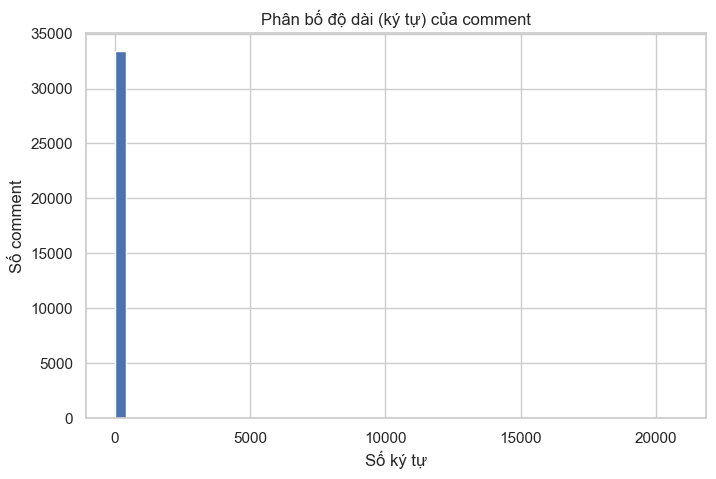

[saved figure] ./eda_outputs\03_length\char_len_hist_overall.png


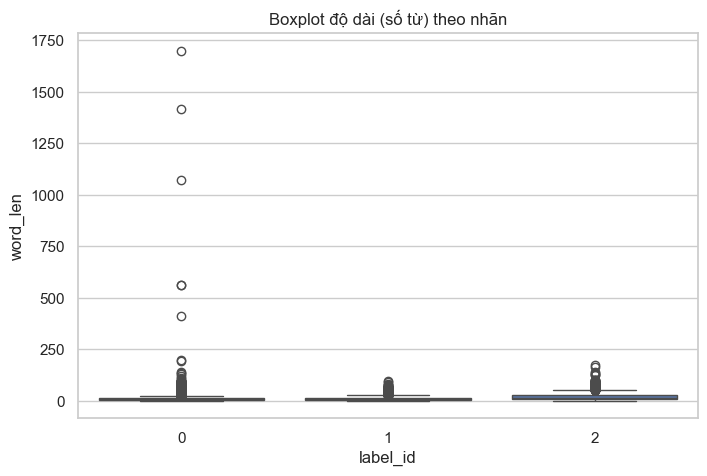

[saved figure] ./eda_outputs\03_length\word_len_boxplot_by_label.png


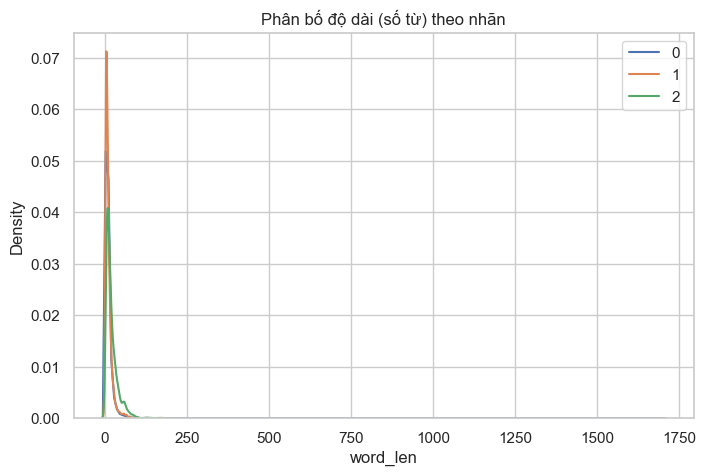

[saved figure] ./eda_outputs\03_length\word_len_kde_by_label.png


In [9]:
# Cell 4: Độ dài comment (ký tự & từ) + lưu thống kê & hình

subdir = "03_length"

# Thêm cột độ dài
texts = df_all[TEXT_COL].astype(str)
df_all["char_len"] = texts.str.len()
df_all["word_len"] = texts.str.split().str.len()

# Thống kê chung
char_len_stats = df_all["char_len"].describe()
word_len_stats = df_all["word_len"].describe()
save_table(char_len_stats, "char_len_overall.csv", subdir=subdir)
save_table(word_len_stats, "word_len_overall.csv", subdir=subdir)

# Thống kê theo nhãn
word_len_by_label = df_all.groupby(LABEL_COL)["word_len"].describe()
save_table(word_len_by_label, "word_len_by_label.csv", subdir=subdir)

# Histogram char_len toàn bộ
plt.figure()
plt.hist(df_all["char_len"], bins=50)
plt.title("Phân bố độ dài (ký tự) của comment")
plt.xlabel("Số ký tự")
plt.ylabel("Số comment")
save_figure("char_len_hist_overall.png", subdir=subdir)

# Boxplot word_len theo nhãn
plt.figure()
sns.boxplot(data=df_all, x=LABEL_COL, y="word_len")
plt.title("Boxplot độ dài (số từ) theo nhãn")
save_figure("word_len_boxplot_by_label.png", subdir=subdir)

# KDE word_len theo nhãn
plt.figure()
for label, sub in df_all.groupby(LABEL_COL):
    sns.kdeplot(data=sub, x="word_len", label=str(label), bw_method="scott")
plt.title("Phân bố độ dài (số từ) theo nhãn")
plt.legend()
save_figure("word_len_kde_by_label.png", subdir=subdir)

## Cell 5 – Emoji, URL, hashtag, mention, số…


=== 04_regex_features/binary_features_rate_by_label.csv ===
          has_emoji  has_url  has_hashtag  has_mention  has_number
label_id                                                          
0          0.123190  0.00076     0.000977     0.004996    0.110737
1          0.090186  0.00000     0.001326     0.002210    0.077365
2          0.058054  0.00000     0.000569     0.010245    0.117245
[saved table] ./eda_outputs\04_regex_features\binary_features_rate_by_label.csv


<Figure size 800x500 with 0 Axes>

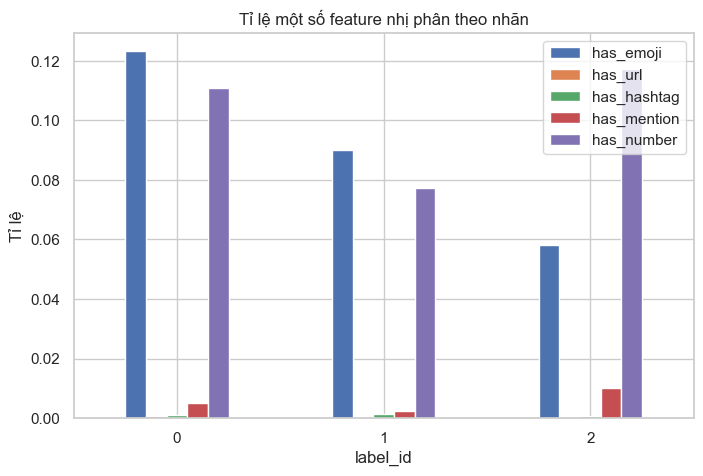

[saved figure] ./eda_outputs\04_regex_features\binary_features_bar_by_label.png

=== 04_regex_features/binary_features_rate_by_split.csv ===
       has_emoji   has_url  has_hashtag  has_mention  has_number
split                                                           
dev     0.110404  0.000000     0.001123     0.003368    0.110030
test    0.116617  0.000299     0.001198     0.005838    0.100449
train   0.113814  0.000790     0.000873     0.005447    0.111485
[saved table] ./eda_outputs\04_regex_features\binary_features_rate_by_split.csv


<Figure size 800x500 with 0 Axes>

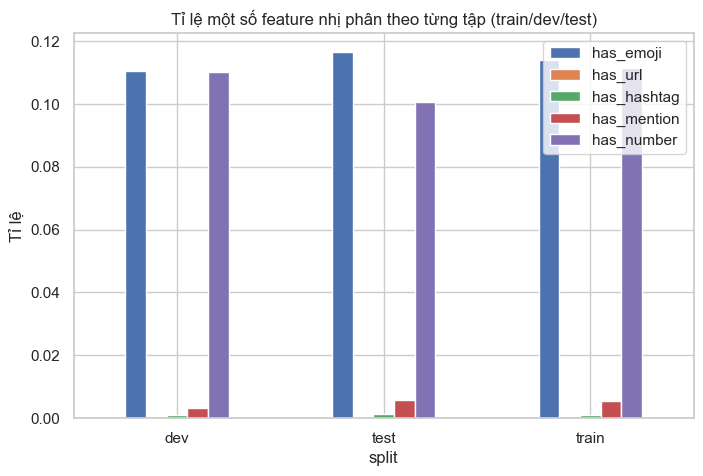

[saved figure] ./eda_outputs\04_regex_features\binary_features_bar_by_split.png

=== 04_regex_features/binary_features_rate_by_split_and_label.csv ===
   split  label_id  has_emoji   has_url  has_hashtag  has_mention  has_number
0    dev         0   0.116438  0.000000     0.001370     0.003196    0.113242
1    dev         1   0.108491  0.000000     0.000000     0.000000    0.070755
2    dev         2   0.062963  0.000000     0.000000     0.007407    0.114815
3   test         0   0.124369  0.000360     0.001262     0.005768    0.102199
4   test         1   0.094595  0.000000     0.002252     0.004505    0.063063
5   test         2   0.068314  0.000000     0.000000     0.007267    0.110465
6  train         0   0.123605  0.000955     0.000855     0.004978    0.112843
7  train         1   0.086550  0.000000     0.001245     0.001868    0.082192
8  train         2   0.054773  0.000000     0.000782     0.011346    0.119327
[saved table] ./eda_outputs\04_regex_features\binary_features_rate_by

<Figure size 800x500 with 0 Axes>

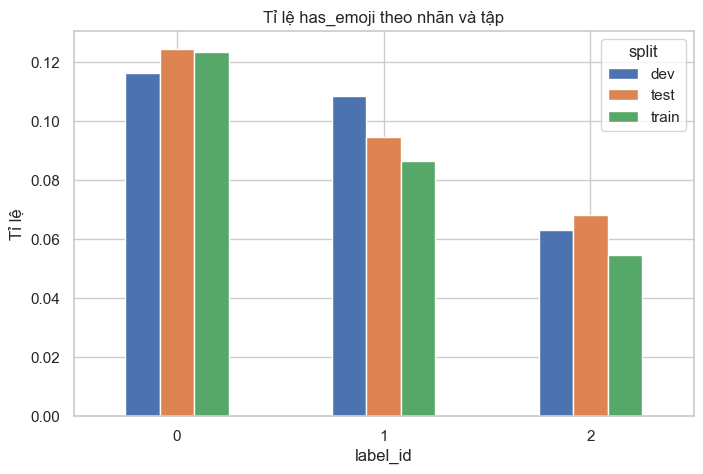

[saved figure] ./eda_outputs\04_regex_features\has_emoji_by_label_and_split.png

=== 04_regex_features/top_emoji_overall.csv ===
     emoji  count
0        😂    489
1        🙂    294
2       😂😂    202
3      😂😂😂    144
4       ❤️    110
5        😆    101
6        😞    100
7        😌     95
8        😁     88
9        ❤     79
10       😀     74
11       😅     70
12       😍     53
13      ♀️     51
14       😢     48
15       🙄     46
16       😄     42
17       👍     37
18       😊     36
19       😑     34
20       🙃     32
21       😏     31
22       😒     31
23    😂😂😂😂     29
24      😆😆     26
25       😘     25
26       😔     23
27       😎     22
28      😁😁     21
29       😥     21
30      😌😌     21
31    ❤️❤️     19
32       😕     19
33       😭     19
34     😍😍😍     18
35       😃     17
36       😗     17
37       😪     17
38     😁😁😁     17
39       🏻     17
40      ❤❤     16
41     😆😆😆     16
42      😅😅     16
43       😶     15
44      😭😭     15
45      ♥️     15
46       😡     15
47     

C:\Users\Admin\AppData\Local\Temp\ipykernel_19128\726898882.py:102: UserWarning: Glyph 128514 (\N{FACE WITH TEARS OF JOY}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Admin\AppData\Local\Temp\ipykernel_19128\726898882.py:102: UserWarning: Glyph 128578 (\N{SLIGHTLY SMILING FACE}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Admin\AppData\Local\Temp\ipykernel_19128\726898882.py:102: UserWarning: Glyph 10084 (\N{HEAVY BLACK HEART}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Admin\AppData\Local\Temp\ipykernel_19128\726898882.py:102: UserWarning: Glyph 65039 (\N{VARIATION SELECTOR-16}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Admin\AppData\Local\Temp\ipykernel_19128\726898882.py:102: UserWarning: Glyph 128518 (\N{SMILING FACE WITH OPEN MOUTH AND TIGHTLY-CLOSED EYES}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\Admin\AppData\Local\Temp\ipykernel_19128\726898882.py:102: UserWarning: Glyph 128542 (\N{DISAPPOINTED FACE}) m

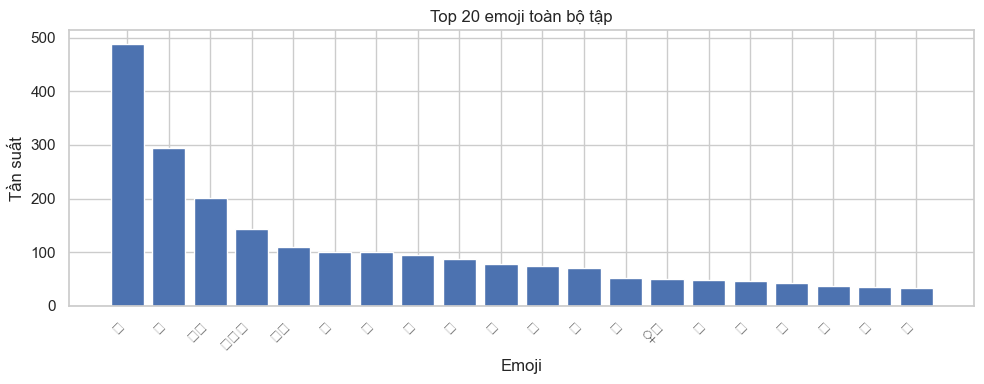

[saved figure] ./eda_outputs\04_regex_features\top_emoji_overall.png

=== 04_regex_features/top_hashtag_overall.csv ===
                      hashtag  count
0                      #error     17
1                       #name      3
2                          #1      2
3                       #trời      1
4                    #binsaid      1
5                       #vtv1      1
6                         #19      1
7                          #c      1
8   #hỗ_trợ_kinh_doanh_online      1
9                   #mcvmedia      1
10                   #comeout      1
11                  #minhhiếu      1
12                 #thử_thách      1
13                       #câu      1
14                     #trang      1
[saved table] ./eda_outputs\04_regex_features\top_hashtag_overall.csv


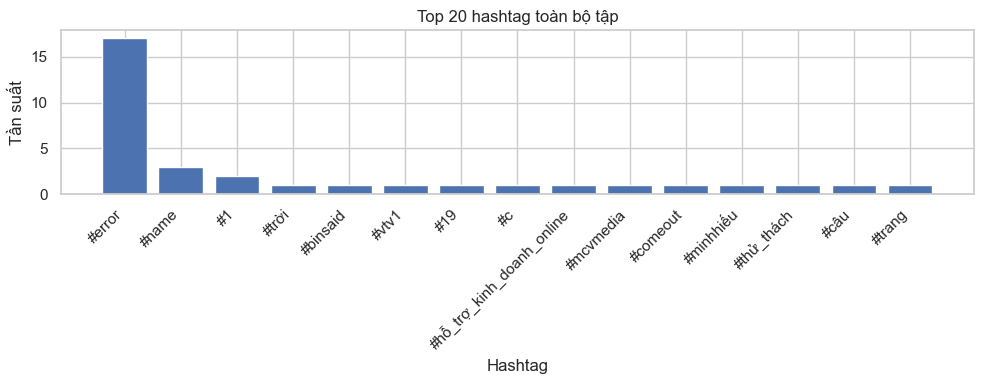

[saved figure] ./eda_outputs\04_regex_features\top_hashtag_overall.png


In [10]:
# Cell 5: Emoji, URL, hashtag, mention, số,... + lưu thống kê & hình

subdir = "04_regex_features"

texts = df_all[TEXT_COL].astype(str)

df_all["emoji_count"] = texts.apply(lambda x: len(EMOJI_PATTERN.findall(x)))
df_all["has_emoji"]   = df_all["emoji_count"] > 0

df_all["url_count"] = texts.apply(lambda x: len(URL_PATTERN.findall(x)))
df_all["has_url"]   = df_all["url_count"] > 0

df_all["hashtag_count"] = texts.apply(lambda x: len(HASHTAG_PATTERN.findall(x)))
df_all["has_hashtag"]   = df_all["hashtag_count"] > 0

df_all["mention_count"] = texts.apply(lambda x: len(MENTION_PATTERN.findall(x)))
df_all["has_mention"]   = df_all["mention_count"] > 0

df_all["has_number"] = texts.apply(lambda x: bool(NUMBER_PATTERN.search(x)))

df_all["exclamation_count"] = texts.str.count(r"!")
df_all["question_count"]    = texts.str.count(r"\?")

binary_features = ["has_emoji", "has_url", "has_hashtag", "has_mention", "has_number"]

# =========================
# 1. TỈ LỆ FEATURE THEO NHÃN
# =========================
binary_by_label = df_all.groupby(LABEL_COL)[binary_features].mean()
save_table(binary_by_label, "binary_features_rate_by_label.csv", subdir=subdir)

plt.figure()
binary_by_label.plot(kind="bar")
plt.title("Tỉ lệ một số feature nhị phân theo nhãn")
plt.ylabel("Tỉ lệ")
plt.xticks(rotation=0)
plt.legend(loc="best")
save_figure("binary_features_bar_by_label.png", subdir=subdir)

# =========================
# 2. TỈ LỆ FEATURE THEO TẬP (train/dev/test)
# =========================
binary_by_split = df_all.groupby("split")[binary_features].mean()
save_table(binary_by_split, "binary_features_rate_by_split.csv", subdir=subdir)

# Barplot theo split
plt.figure()
binary_by_split.plot(kind="bar")
plt.title("Tỉ lệ một số feature nhị phân theo từng tập (train/dev/test)")
plt.ylabel("Tỉ lệ")
plt.xticks(rotation=0)
plt.legend(loc="best")
save_figure("binary_features_bar_by_split.png", subdir=subdir)

# =========================
# 3. (TUỲ CHỌN) TỈ LỆ THEO CẢ NHÃN & TẬP
#    Hữu ích nếu sau này bạn muốn phân tích sâu hơn.
# =========================
binary_by_split_label = (
    df_all
    .groupby(["split", LABEL_COL])[binary_features]
    .mean()
    .reset_index()
)

save_table(binary_by_split_label, "binary_features_rate_by_split_and_label.csv", subdir=subdir)

# Nếu muốn trực quan hoá chi tiết, có thể vẽ riêng từng feature:
# Ví dụ minh hoạ: barplot cho 'has_emoji' theo (split, label)
plt.figure(figsize=(8, 5))
pivot_emoji = (
    df_all
    .groupby(["split", LABEL_COL])["has_emoji"]
    .mean()
    .unstack("split")
)
pivot_emoji.plot(kind="bar")
plt.title("Tỉ lệ has_emoji theo nhãn và tập")
plt.ylabel("Tỉ lệ")
plt.xticks(rotation=0)
plt.legend(title="split", loc="best")
save_figure("has_emoji_by_label_and_split.png", subdir=subdir)

# =========================
# 4. TOP EMOJI & TOP HASHTAG OVERALL
# =========================
emoji_counter = Counter()
for ems in texts.apply(lambda x: EMOJI_PATTERN.findall(x)):
    emoji_counter.update(ems)
if emoji_counter:
    emoji_df = pd.DataFrame(emoji_counter.most_common(50), columns=["emoji", "count"])
    save_table(emoji_df, "top_emoji_overall.csv", subdir=subdir)

    # Trực quan hoá top emoji (optional)
    top_emoji_plot = emoji_df.head(20)
    plt.figure(figsize=(10, 4))
    plt.bar(top_emoji_plot["emoji"], top_emoji_plot["count"])
    plt.title("Top 20 emoji toàn bộ tập")
    plt.xlabel("Emoji")
    plt.ylabel("Tần suất")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    save_figure("top_emoji_overall.png", subdir=subdir)

hashtag_counter = Counter()
for hs in texts.apply(lambda x: HASHTAG_PATTERN.findall(x)):
    hashtag_counter.update([h.lower() for h in hs])
if hashtag_counter:
    hashtag_df = pd.DataFrame(hashtag_counter.most_common(50), columns=["hashtag", "count"])
    save_table(hashtag_df, "top_hashtag_overall.csv", subdir=subdir)

    # Trực quan hoá top hashtag (optional)
    top_hashtag_plot = hashtag_df.head(20)
    plt.figure(figsize=(10, 4))
    plt.bar(top_hashtag_plot["hashtag"], top_hashtag_plot["count"])
    plt.title("Top 20 hashtag toàn bộ tập")
    plt.xlabel("Hashtag")
    plt.ylabel("Tần suất")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    save_figure("top_hashtag_overall.png", subdir=subdir)


## Cell 6 – Stopword, vocab, tỉ lệ nội dung


=== 05_stopwords_vocab/stop_ratio_overall.csv ===
count    33090.000000
mean         0.369179
std          0.232427
min          0.000000
25%          0.200000
50%          0.392857
75%          0.518519
max          1.000000
Name: stop_ratio, dtype: float64
[saved table] ./eda_outputs\05_stopwords_vocab\stop_ratio_overall.csv

=== 05_stopwords_vocab/stop_ratio_by_label.csv ===
            count      mean       std  min       25%       50%       75%  max
label_id                                                                     
0         27315.0  0.373475  0.237435  0.0  0.200000  0.400000  0.533333  1.0
1          2261.0  0.324654  0.224497  0.0  0.142857  0.333333  0.500000  1.0
2          3514.0  0.364435  0.191428  0.0  0.230769  0.394737  0.500000  1.0
[saved table] ./eda_outputs\05_stopwords_vocab\stop_ratio_by_label.csv


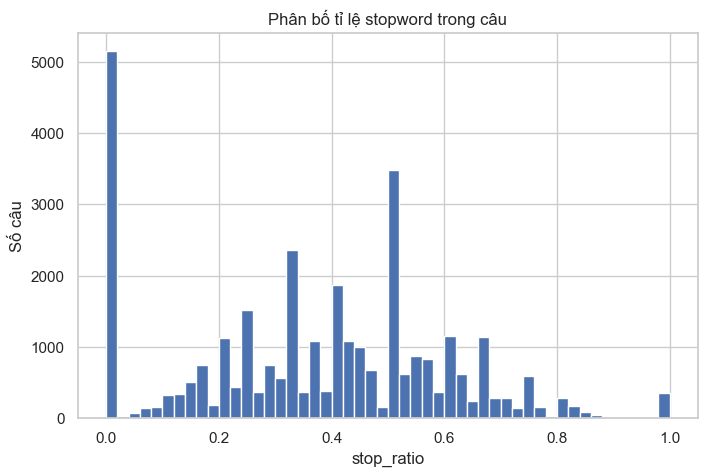

[saved figure] ./eda_outputs\05_stopwords_vocab\stop_ratio_hist.png


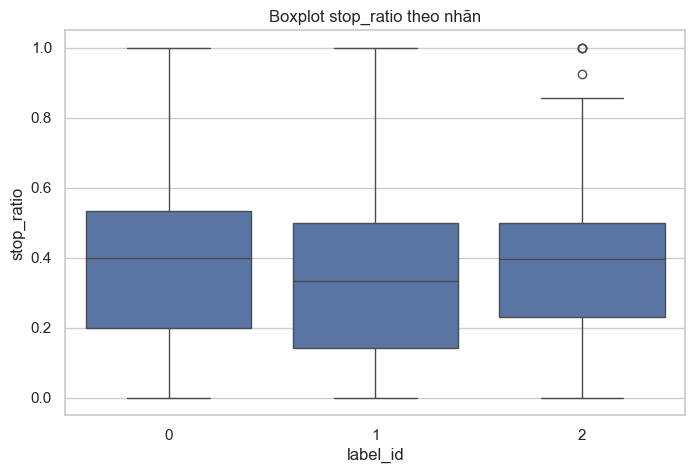

[saved figure] ./eda_outputs\05_stopwords_vocab\stop_ratio_box_by_label.png

=== 05_stopwords_vocab/vocab_size_and_jaccard.csv ===
       vocab_size  jaccard_vs_train
split                              
train       10682          1.000000
dev          3832          0.306861
test         5815          0.396512
[saved table] ./eda_outputs\05_stopwords_vocab\vocab_size_and_jaccard.csv


In [11]:
# Cell 6: Stopword, độ đậm nội dung & từ vựng

subdir = "05_stopwords_vocab"

tokens_series_all = df_all[TEXT_COL].astype(str).apply(simple_tokenize)

df_all["token_count"] = tokens_series_all.apply(len)
df_all["stop_count"] = tokens_series_all.apply(
    lambda toks: sum(1 for t in toks if t in VI_STOPWORDS)
)
df_all["content_count"] = df_all["token_count"] - df_all["stop_count"]
df_all["stop_ratio"] = df_all["stop_count"] / df_all["token_count"].replace(0, np.nan)

# Thống kê stop_ratio chung & theo nhãn
stop_ratio_stats = df_all["stop_ratio"].describe()
save_table(stop_ratio_stats, "stop_ratio_overall.csv", subdir=subdir)

stop_ratio_by_label = df_all.groupby(LABEL_COL)["stop_ratio"].describe()
save_table(stop_ratio_by_label, "stop_ratio_by_label.csv", subdir=subdir)

# Histogram stop_ratio
plt.figure()
plt.hist(df_all["stop_ratio"].dropna(), bins=50)
plt.title("Phân bố tỉ lệ stopword trong câu")
plt.xlabel("stop_ratio")
plt.ylabel("Số câu")
save_figure("stop_ratio_hist.png", subdir=subdir)

# Boxplot stop_ratio theo nhãn
plt.figure()
sns.boxplot(data=df_all, x=LABEL_COL, y="stop_ratio")
plt.title("Boxplot stop_ratio theo nhãn")
save_figure("stop_ratio_box_by_label.png", subdir=subdir)

# Hàm lấy vocab từ 1 DataFrame
def vocab_from_df(df, text_col):
    vocab = set()
    for text in df[text_col].astype(str):
        tokens = simple_tokenize(text)
        vocab.update(tokens)
    return vocab

vocab_train = vocab_from_df(train_df, TEXT_COL)
vocab_dev   = vocab_from_df(dev_df, TEXT_COL)
vocab_test  = vocab_from_df(test_df, TEXT_COL)

def jaccard(a, b):
    inter = len(a & b)
    union = len(a | b)
    return inter / union if union > 0 else np.nan

vocab_stats = pd.DataFrame(
    {
        "split": ["train", "dev", "test"],
        "vocab_size": [len(vocab_train), len(vocab_dev), len(vocab_test)],
        "jaccard_vs_train": [
            1.0,
            jaccard(vocab_train, vocab_dev),
            jaccard(vocab_train, vocab_test),
        ],
    }
).set_index("split")
save_table(vocab_stats, "vocab_size_and_jaccard.csv", subdir=subdir)

## Cell 7 – Slang / kéo dài chữ (subdir 06_slang_elongated)


=== 06_slang_elongated/slang_elongated_rate_by_label.csv ===
          has_slang  has_elongated
label_id                          
0          0.037902       0.153417
1          0.356322       0.149425
2          0.250711       0.163631
[saved table] ./eda_outputs\06_slang_elongated\slang_elongated_rate_by_label.csv

=== 06_slang_elongated/top_slang_words.csv ===
   slang  count
0     mẹ    688
1     vl    565
2    đéo    502
3     bố    319
4    lồn    257
5     đm    198
6    lol    163
7     cc    159
8    vcl    128
9     dm    119
10   địt     95
11    đụ     58
12    cl     50
13   clm     34
14   dkm     21
15   cmm     14
16   wtf     10
[saved table] ./eda_outputs\06_slang_elongated\top_slang_words.csv


<Figure size 800x500 with 0 Axes>

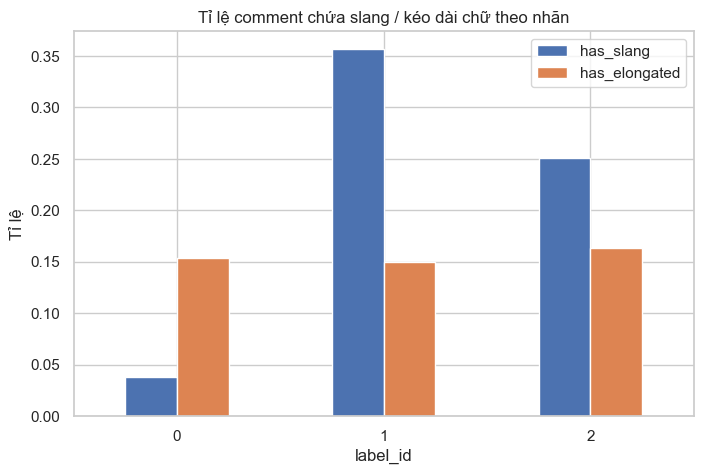

[saved figure] ./eda_outputs\06_slang_elongated\slang_elongated_bar_by_label.png


In [12]:
# Cell 7: Slang / teencode & kéo dài chữ

subdir = "06_slang_elongated"

tokens_series_all = df_all[TEXT_COL].astype(str).apply(simple_tokenize)

df_all["slang_count"] = tokens_series_all.apply(
    lambda toks: sum(1 for t in toks if t in SLANG_WORDS)
)
df_all["has_slang"] = df_all["slang_count"] > 0

texts = df_all[TEXT_COL].astype(str)
df_all["elongated_count"] = texts.apply(lambda x: len(ELONGATED_PATTERN.findall(x)))
df_all["has_elongated"]   = df_all["elongated_count"] > 0

slang_features = ["has_slang", "has_elongated"]

slang_by_label = df_all.groupby(LABEL_COL)[slang_features].mean()
save_table(slang_by_label, "slang_elongated_rate_by_label.csv", subdir=subdir)

# Top slang words
slang_counter = Counter()
for toks in tokens_series_all:
    slang_counter.update([t for t in toks if t in SLANG_WORDS])
if slang_counter:
    slang_df = pd.DataFrame(
        slang_counter.most_common(50), columns=["slang", "count"]
    )
    save_table(slang_df, "top_slang_words.csv", subdir=subdir)

# Barplot tỉ lệ theo nhãn
plt.figure()
slang_by_label.plot(kind="bar")
plt.title("Tỉ lệ comment chứa slang / kéo dài chữ theo nhãn")
plt.ylabel("Tỉ lệ")
plt.xticks(rotation=0)
plt.legend(loc="best")
save_figure("slang_elongated_bar_by_label.png", subdir=subdir)


## Cell 8 – Comment rất ngắn & chỉ emoji/punctuation


=== 07_short_special/short_and_emoji_only_overall.csv ===
is_very_short       0.067006
only_emoji_punct    0.009401
dtype: float64
[saved table] ./eda_outputs\07_short_special\short_and_emoji_only_overall.csv

=== 07_short_special/short_and_emoji_only_by_label.csv ===
          is_very_short  only_emoji_punct
label_id                                 
0              0.070555          0.011331
1              0.103006          0.000442
2              0.015936          0.000000
[saved table] ./eda_outputs\07_short_special\short_and_emoji_only_by_label.csv


<Figure size 800x500 with 0 Axes>

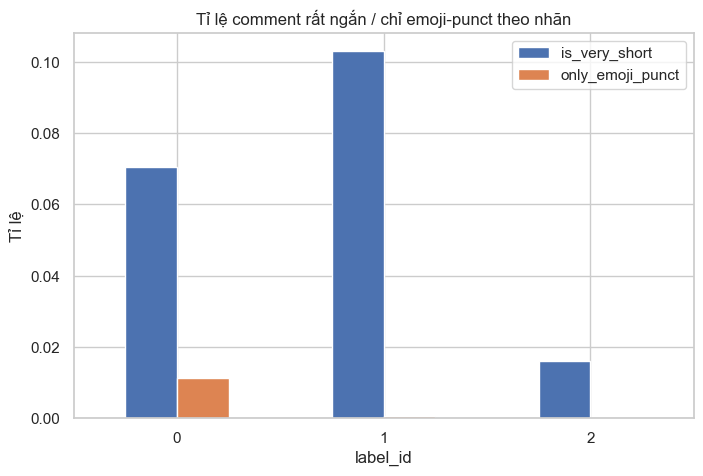

[saved figure] ./eda_outputs\07_short_special\short_emoji_only_bar_by_label.png


In [13]:
# Cell 8: Comment rất ngắn & chỉ emoji/punctuation

subdir = "07_short_special"

# Giả sử df_all đã có cột word_len từ Cell 4
df_all["is_very_short"] = df_all["word_len"] <= 2

def only_emoji_punct(text):
    if not isinstance(text, str):
        return False
    if not text.strip():
        return False
    # nếu có chữ cái hoặc số thì không phải "chỉ emoji/punct"
    if ALPHA_DIGIT_PATTERN.search(text):
        return False
    return True

df_all["only_emoji_punct"] = df_all[TEXT_COL].astype(str).apply(only_emoji_punct)

short_overall = df_all[["is_very_short", "only_emoji_punct"]].mean()
save_table(short_overall, "short_and_emoji_only_overall.csv", subdir=subdir)

short_by_label = df_all.groupby(LABEL_COL)[["is_very_short", "only_emoji_punct"]].mean()
save_table(short_by_label, "short_and_emoji_only_by_label.csv", subdir=subdir)

# Barplot theo nhãn
plt.figure()
short_by_label.plot(kind="bar")
plt.title("Tỉ lệ comment rất ngắn / chỉ emoji-punct theo nhãn")
plt.ylabel("Tỉ lệ")
plt.xticks(rotation=0)
save_figure("short_emoji_only_bar_by_label.png", subdir=subdir)

## Cell 9 – Phân bố nhãn theo split (hình)

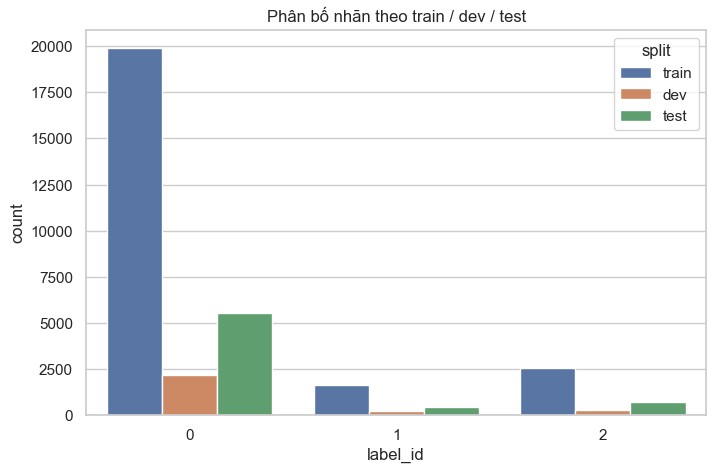

[saved figure] ./eda_outputs\08_label_distribution\label_distribution_by_split.png


In [14]:
# Cell 9: Trực quan hoá phân bố nhãn theo split

subdir = "08_label_distribution"

plt.figure()
sns.countplot(data=df_all, x=LABEL_COL, hue="split")
plt.title("Phân bố nhãn theo train / dev / test")
plt.xticks(rotation=0)
save_figure("label_distribution_by_split.png", subdir=subdir)

## Cell 10 – TF-IDF & sparsity


=== 09_tfidf_sparsity/tfidf_sparsity_info.csv ===
   n_docs  n_features     nnz   density
0   24048        5896  232649  0.001641
[saved table] ./eda_outputs\09_tfidf_sparsity\tfidf_sparsity_info.csv

=== 09_tfidf_sparsity/tfidf_nonzero_per_doc_stats.csv ===
count    24048.00000
mean         9.67436
std         11.27398
min          0.00000
25%          4.00000
50%          7.00000
75%         12.00000
max        611.00000
dtype: float64
[saved table] ./eda_outputs\09_tfidf_sparsity\tfidf_nonzero_per_doc_stats.csv


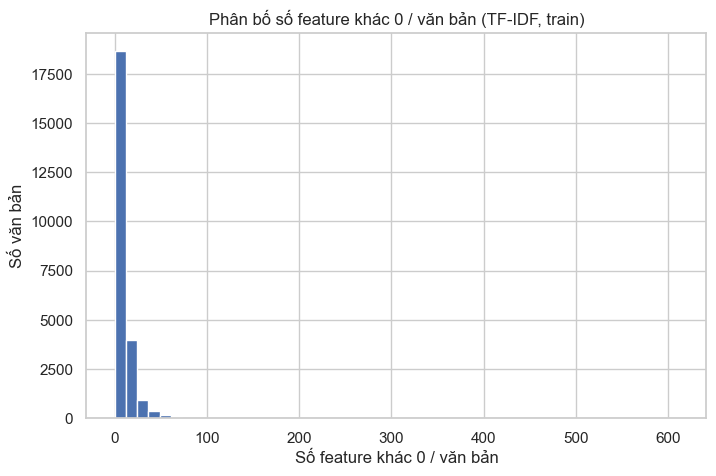

[saved figure] ./eda_outputs\09_tfidf_sparsity\tfidf_nonzero_per_doc_hist.png


In [15]:
# Cell 10: TF-IDF & độ thưa (sparsity)

subdir = "09_tfidf_sparsity"

MAX_FEATURES = 50000
MIN_DF = 2

tfidf_vectorizer = TfidfVectorizer(
    max_features=MAX_FEATURES,
    min_df=MIN_DF
)
X_tfidf = tfidf_vectorizer.fit_transform(train_df[TEXT_COL].astype(str))

nnz = X_tfidf.nnz
total = X_tfidf.shape[0] * X_tfidf.shape[1]
density = nnz / total

sparsity_info = pd.DataFrame(
    {
        "n_docs": [X_tfidf.shape[0]],
        "n_features": [X_tfidf.shape[1]],
        "nnz": [nnz],
        "density": [density],
    }
)
save_table(sparsity_info, "tfidf_sparsity_info.csv", subdir=subdir)

nonzero_per_doc = np.diff(X_tfidf.indptr)
nonzero_stats = pd.Series(nonzero_per_doc).describe()
save_table(nonzero_stats, "tfidf_nonzero_per_doc_stats.csv", subdir=subdir)

plt.figure()
plt.hist(nonzero_per_doc, bins=50)
plt.xlabel("Số feature khác 0 / văn bản")
plt.ylabel("Số văn bản")
plt.title("Phân bố số feature khác 0 / văn bản (TF-IDF, train)")
save_figure("tfidf_nonzero_per_doc_hist.png", subdir=subdir)

## Cell 11 – Top n-gram theo nhãn (lưu CSV)


=== 10_ngrams/top_unigram_label_0.csv ===
   unigram  count
0       đi   2085
1       ko   1433
2     thầy   1421
3        k   1102
4   nguyễn   1098
5        a   1071
6        v    901
7      nha    818
8        1    811
9      chi    795
10       t    769
11      đc    724
12       3    694
13    trần    683
14    minh    683
15     mấy    664
16       e    649
17       i    645
18     đẹp    640
19      ta    606
20      ng    582
21     lắm    581
22     nam    578
23     abe    543
24     yêu    540
25    tiền    537
26    cười    519
27       c    517
28    phục    511
29     đấy    498
30    việt    491
31     dân    485
32  thuyết    483
33      độ    467
34     cực    466
35    sống    465
36  thương    462
37     học    456
38       m    454
39     vui    441
40   hoàng    435
41       n    429
42   trung    424
43    công    412
44     mua    404
45    chửi    403
46   thành    395
47      co    394
48      vô    393
49      vl    381
[saved table] ./eda_outputs\10_ngrams\t

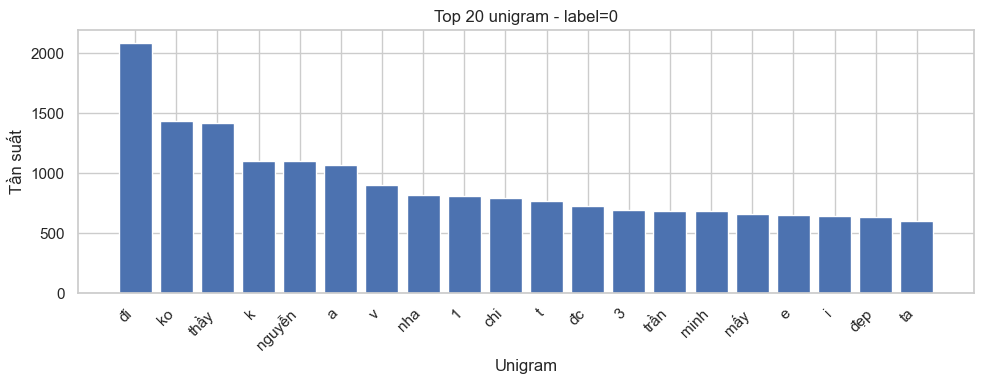

[saved figure] ./eda_outputs\10_ngrams\top_unigram_label_0.png


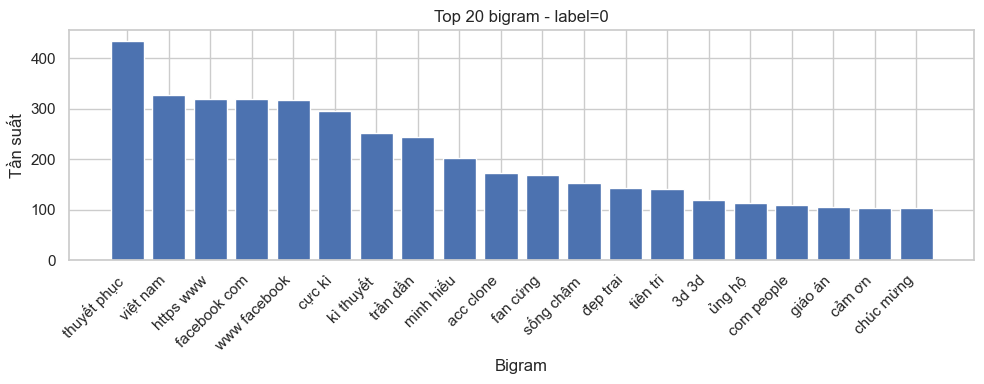

[saved figure] ./eda_outputs\10_ngrams\top_bigram_label_0.png

=== 10_ngrams/top_unigram_label_2.csv ===
   unigram  count
0       đi    496
1       ko    427
2    thằng    415
3      dân    369
4      mày    365
5       mẹ    288
6      ngu    282
7      mấy    275
8      bọn    263
9      chó    262
10       m    253
11      ng    233
12    chửi    225
13      ta    225
14    tiền    197
15       i    189
16     đéo    188
17       t    186
18    chết    179
19      ad    173
20       k    171
21    thầy    154
22      vn    151
23     lồn    151
24    việt    150
25      no    150
26     tao    147
27       c    146
28     mặt    146
29      ma    143
30       n    137
31     nam    134
32      lũ    133
33      la    133
34       1    132
35    quan    132
36       a    132
37    công    128
38      đc    126
39    cộng    120
40     tụi    118
41     đầu    117
42      co    116
43       3    113
44     học    112
45    toàn    111
46       y    110
47     lắm    109
48      vô   

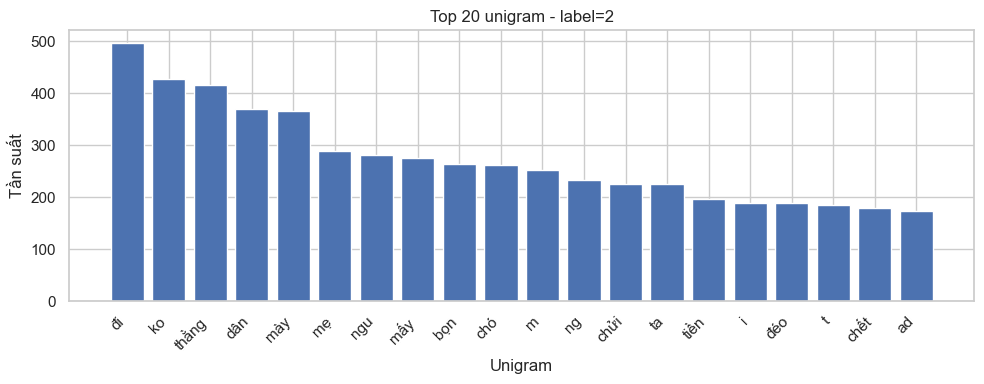

[saved figure] ./eda_outputs\10_ngrams\top_unigram_label_2.png


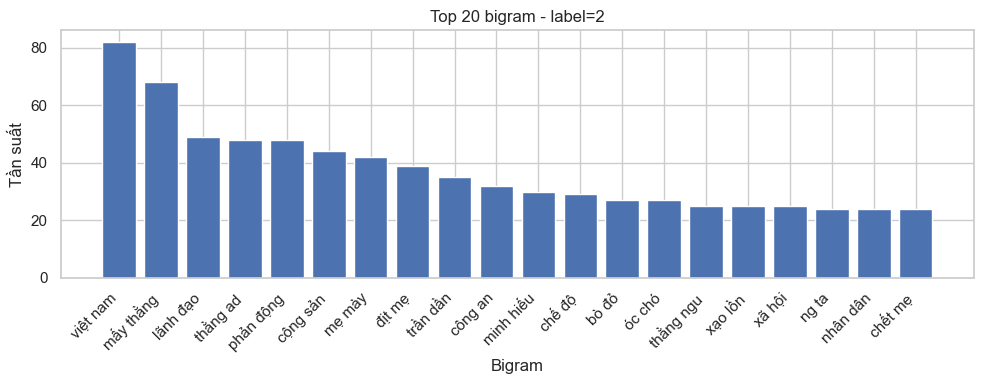

[saved figure] ./eda_outputs\10_ngrams\top_bigram_label_2.png

=== 10_ngrams/top_unigram_label_1.csv ===
   unigram  count
0       đi    189
1      đéo    183
2       vl    137
3       mẹ    131
4       ko    105
5      lồn     87
6      dân     84
7        t     81
8     tiền     77
9        v     76
10       k     75
11     vãi     74
12       1     73
13    chết     71
14     ngu     67
15      đc     67
16      cc     62
17    chửi     60
18      đm     60
19     chó     58
20   thằng     57
21     lol     56
22     tao     56
23     vcl     54
24      ng     52
25      má     50
26       j     50
27       n     49
28      dm     49
29       m     49
30     mấy     48
31       i     47
32      ta     44
33       a     43
34       c     42
35     đầu     41
36    thức     40
37      ma     40
38       l     40
39  nguyễn     40
40    công     40
41     lắm     39
42    quan     37
43    quần     36
44     mày     35
45     mặt     35
46     đấy     34
47    toàn     34
48    sống   

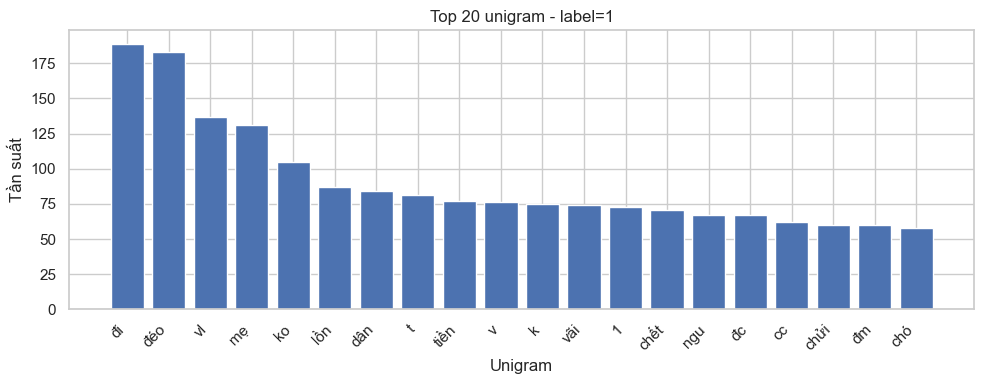

[saved figure] ./eda_outputs\10_ngrams\top_unigram_label_1.png


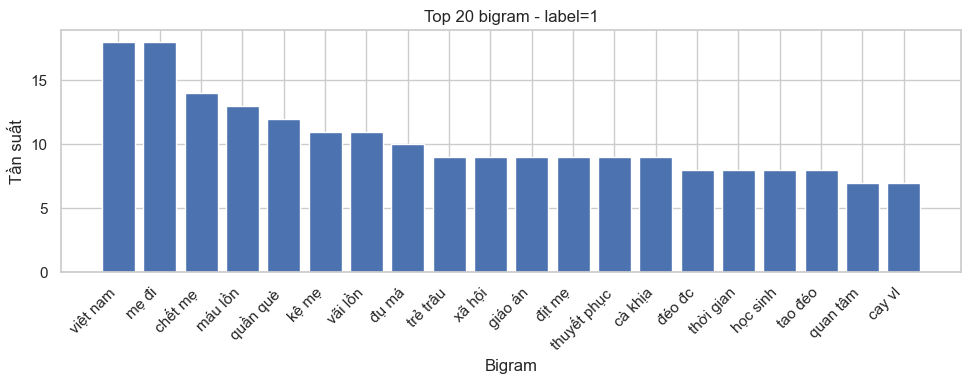

[saved figure] ./eda_outputs\10_ngrams\top_bigram_label_1.png


In [16]:
# Cell 11: Top n-gram theo nhãn, lưu CSV và trực quan hoá

subdir = "10_ngrams"

def top_ngrams(texts, n=1, top_k=50, stopwords=None):
    counter = Counter()
    for text in texts:
        tokens = simple_tokenize(text)
        if stopwords:
            tokens = [t for t in tokens if t not in stopwords]
        if n == 1:
            ngrams = tokens
        else:
            ngrams = zip(*[tokens[i:] for i in range(n)])
            ngrams = [" ".join(g) for g in ngrams]
        counter.update(ngrams)
    return counter.most_common(top_k)

unique_labels = df_all[LABEL_COL].unique()

# Số lượng top n-gram sẽ vẽ (đọc cho dễ, không nên quá nhiều)
PLOT_TOP_K = 20  # bạn có thể tăng/giảm nếu muốn

for label in unique_labels:
    subset = df_all[df_all[LABEL_COL] == label]
    texts_label = subset[TEXT_COL].astype(str)

    # Thống kê n-gram
    top_uni = top_ngrams(texts_label, n=1, top_k=50, stopwords=VI_STOPWORDS)
    top_bi  = top_ngrams(texts_label, n=2, top_k=50, stopwords=VI_STOPWORDS)

    uni_df = pd.DataFrame(top_uni, columns=["unigram", "count"])
    bi_df  = pd.DataFrame(top_bi,  columns=["bigram", "count"])

    safe_label = str(label).lower()
    uni_name = f"top_unigram_label_{safe_label}.csv"
    bi_name  = f"top_bigram_label_{safe_label}.csv"

    # Lưu bảng CSV (và in ra)
    save_table(uni_df, uni_name, subdir=subdir)
    save_table(bi_df,  bi_name,  subdir=subdir)

    # ----------------------------
    # VẼ BAR CHART UNIGRAM (TOP_K)
    # ----------------------------
    uni_plot_df = uni_df.head(PLOT_TOP_K)

    plt.figure(figsize=(10, 4))
    plt.bar(uni_plot_df["unigram"], uni_plot_df["count"])
    plt.title(f"Top {PLOT_TOP_K} unigram - label={label}")
    plt.xlabel("Unigram")
    plt.ylabel("Tần suất")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    save_figure(f"top_unigram_label_{safe_label}.png", subdir=subdir)

    # ----------------------------
    # VẼ BAR CHART BIGRAM (TOP_K)
    # ----------------------------
    bi_plot_df = bi_df.head(PLOT_TOP_K)

    plt.figure(figsize=(10, 4))
    plt.bar(bi_plot_df["bigram"], bi_plot_df["count"])
    plt.title(f"Top {PLOT_TOP_K} bigram - label={label}")
    plt.xlabel("Bigram")
    plt.ylabel("Tần suất")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    save_figure(f"top_bigram_label_{safe_label}.png", subdir=subdir)


## Cell 12 – Word cloud theo nhãn (subdir 11_wordclouds)

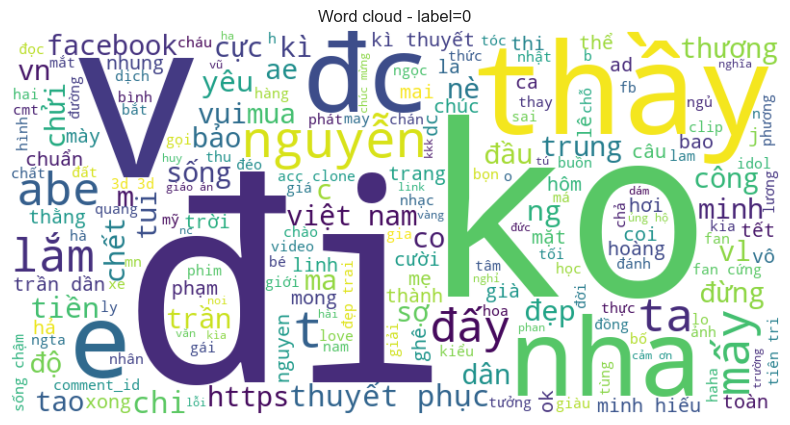

[saved figure] ./eda_outputs\11_wordclouds\wordcloud_label_0.png


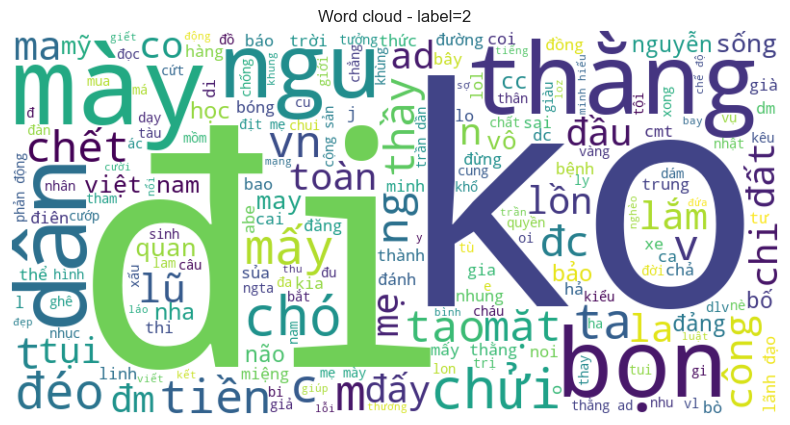

[saved figure] ./eda_outputs\11_wordclouds\wordcloud_label_2.png


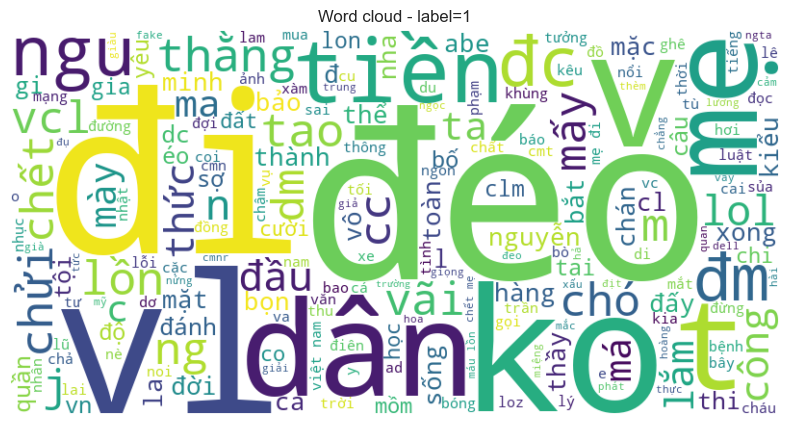

[saved figure] ./eda_outputs\11_wordclouds\wordcloud_label_1.png


In [17]:
# Cell 12: Word cloud cho từng nhãn (nếu đã cài wordcloud)

subdir = "11_wordclouds"

if not HAS_WORDCLOUD:
    print("Chưa cài thư viện 'wordcloud' nên bỏ qua bước này.")
else:
    for label in unique_labels:
        subset = df_all[df_all[LABEL_COL] == label]
        text_all = " ".join(subset[TEXT_COL].astype(str).tolist())
        tokens = [t for t in simple_tokenize(text_all) if t not in VI_STOPWORDS]
        text_clean = " ".join(tokens)

        if not text_clean.strip():
            print(f"Không đủ dữ liệu để vẽ word cloud cho nhãn {label}")
            continue

        wc = WordCloud(width=800, height=400, background_color="white").generate(text_clean)

        plt.figure(figsize=(10, 5))
        plt.imshow(wc, interpolation="bilinear")
        plt.axis("off")
        plt.title(f"Word cloud - label={label}")
        safe_label = str(label).lower()
        save_figure(f"wordcloud_label_{safe_label}.png", subdir=subdir)
